In [1]:
# Testing Pacman
import postprocess as pp
import plots as plots
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

from pathlib import Path 

postproc


In [3]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)


## Analyis helps

In [4]:
def _critical_load(matpar):
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]
    return np.sqrt(8*_w1 / (_mu*_k)/4)
    # independent of _N**2


def _homogeneous_state(t, matpar):
    """docstring for _homogeneous_state"""
    _mu, _k, _w1, _N = matpar["mu"], matpar["k"], matpar["w1"], matpar["N"]


    # _tc = np.sqrt(matpar/k)
    # _a = (tau - 1) / (_k - 1)

    _tc = _critical_load(params["model"])
    _uh = [0 for i in range(0, _N+1)]
    
    if t <= _tc:
        # elastic
        _alphah = [0. for i in range(0, _N)]
        _uh = [i*t/_N for i in range(0, _N+1)]
    else:   
        # damaging
        _α = (t/_tc - 1) / (_k - 1)
        _alphah = [_α for i in range(0, _N)]

        # _S = reduce(lambda a, b: a+b, list(map(a_atk, _alphah)))
        
        _S = _N*a_atk(_α)

        _e = t / _N
        for i in range(0, _N+1):
            if i == 0:
                _uh[i] = 0
            else: 
                _uh[i] = _e * i
        # _uh = [a_atk(_α) / (_N*a_atk(_α)) * i/_N for i in range(0, _N+1)]
        # print(t, _e)
    return _alphah, _uh

In [5]:
class DefaultDamage:
    def __init__(self, state, matpar, name = "Default damage model: atk aka JJK aka LS"):
        self.state = state
        self.matpar = matpar
        self.str = name

    def _a(self, α):
        _α = state[α]
        # _α = α
        # _E0 = self.matpar[E0]
        _k = self.matpar[k]

        return (1 - α) / ((_k-1) * α + 1)

    def _w(self, _α):
        _α = α
        # _w1 = self.matpar[w1]

        return _α

    def energy(self, state):
        """Total energy"""
        return self._elastic(state) + self._damage(state) - self.work(state)

    def work(self, state):
        return 0

    def _elastic(self, state):
        _E0 = self.matpar[E0]
        _u = state[u]
        _α = state[α]

        return 1./2. * _E0 * self._a(_α) * sp.diff(_u, x)**2 

    def _damage(self, state):
        _α = state[α]
        _w1 = matpar[w1]
        _η = matpar[η]

        return _w1 * (self._w(_α) + matpar[η]**2 * sp.diff(_α, x)) 


    def __str__(self):
     return self.str


class DamageATSN(DefaultDamage):
    """docstring for Model"""
    def __init__(self, state, matpar, name = "ATk Damage Model, Seb Neukirch"):
        super(DefaultDamage, self).__init__(matpar, name = "Damage Model")

    def _a(self, state):
        α = state[α]
        _E0 = self.matpar[E0]

        # return (1 - α)**2

    def _w(self, _α):
        _α = α
        _n = self.matpar[n]
        return 1-(1.-_α)**2


class DamageATn(DefaultDamage):
    """docstring for Model"""
    def __init__(self, state, matpar, name = "ATn Damage Model"):
        super(DamageATn, self).__init__(state, matpar, name = "Damage Model")

    def _a(self, α):
        return (1 - α)**2

    def _w(self, _α):
        _α = α
        _n = self.matpar[n]
        return _α**_n


class DamagePQ(DefaultDamage):
    """Particularly interesting model, as per marigo-2012"""
    def __init__(self, state, matpar = {}, name = "PQ Damage Model"):
        if matpar == {}:
            p, q, E0, L, w1, η, σc = sp.symbols('p q E0 L w1 η σc')
            _matpar = {p: p, q: q, E0: E0, w1: w1, η: η, L: L, σc: σc}
            self._matpar = _matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, _matpar, name = "PQ Damage Model")

    def _a(self, α):
        _q = self._matpar[q]
        _p = self._matpar[p]

        return (1 - α)**_q / (1 + α)**_p  

    def _w(self, _α):
        
        
        _α = α
        _q = self._matpar[q]
        _p = self._matpar[p]
        _σc = self._matpar[σc]
        _E0 = self._matpar[E0]

        return (_p+_q) * _α * _σc**2 / _E0


class DamagePQ2(DefaultDamage):
    """Particularly interesting other model, as per marigo-2012, 
        Requires: q > p > 0
    """
    def __init__(self, state, matpar = {}, name = "PQ Damage Model"):
        if matpar == {}:
            p, q, E0, L, w1, η, σc = sp.symbols('p q E0 L w1 η σc')
            _matpar = {p: p, q: q, E0: E0, w1: w1, η: η, L: L, σc: σc}
            self._matpar = _matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, _matpar, name = "PQ Damage Model")

    def _a(self, α):
        _q = self._matpar[q]
        _p = self._matpar[p]

        return (1 - α)**_q 

    def _w(self, _α):
        
        _α = α
        _q = self._matpar[q]
        _p = self._matpar[p]
        _σc = self._matpar[σc]
        _E0 = self._matpar[E0]

        return _q * _σc**2 / (2.* _p * _E0)  * (1.-(1.-_α)**_p)


class PerfectBrittle(DefaultDamage):
    """Perfectly brittle model, as per marigo-2012, 
        w'/E' is constant
    """
    def __init__(self, state, matpar = {}, name = "PQ Damage Model"):
        if matpar == {}:
            p, q, E0, L, w1, η, σc = sp.symbols('p q E0 L w1 η σc')
            _matpar = {p: p, q: q, E0: E0, w1: w1, η: η, L: L, σc: σc}
            self._matpar = _matpar
            # TODO: fix redundancies, like below
            # self.matpar = _matpar

        super(DamagePQ, self).__init__(state, _matpar, name = "PQ Damage Model")

    def _a(self, α):
        _q = self._matpar[q]
        _p = self._matpar[p]

        # return (1 - α)**_q 
        # return ?

    def _w(self, _α):
        
        _α = α
        _σc = self._matpar[σc]
        _E0 = self._matpar[E0]
        _ec = _σc / _E0

        return _E0 * (1 - self._a) * _ec**2 /2.


In [6]:
## Simple Analytic 
# import visuals
E0, L, w1, η, σc = sp.symbols('E0 L w1 η σc')
# k = sp.symbols('k', integer = True)
x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)


### Homogeneous sound solution
<!-- u = tx -->
<!-- alpha = 0 -->

In [35]:
class ModelAnalysis:
    """Helper class to analyse stability properties of a model"""
    def __init__(self, model):
        self.model = model
        self.state = model.state
        self.matpar = model.matpar

        self._s = 1/self.model._a(state[α])
        self._sp = sp.diff(self._s, state[α], 1)
        self._spp = sp.diff(self._s, state[α], 2)

        self._a = self.model._a(state[α])
        self._ap = sp.diff(self._a, state[α], 1)
        self._app = sp.diff(self._a, state[α], 2)

        self._w = self.model._w(state[α])
        self._wp = sp.diff(self.model._w(state[α]), state[α])

    def criterion(self):
        """Damage onset"""
        model, state = self.model, self.state

        _u0 = t*x/L
        _alpha0 = 0 

        _crit = sp.diff(model.energy(state), α) \
            .subs({u: _u0, α: _alpha0})         \
            .simplify()
            # .subs(matpar).simplify()
        

        # _ts = np.array(sp.solve(_crit, t))
        # return np.where(_ts > 0)
        self.crit = _crit

        return _crit

    def _homogeneous_energy(self, _matpar):
        state, (_uf, _af) = self._homogeneous_state(_matpar)

        _u = state[0]
        _alpha = state[1]

        return

    def critical_load(self):
        return sp.solve(self.crit, t**2, 0)

    def critical_load_N(self, _matpar = {}):
        _crits = sp.solve(t**2 - self.critical_load()[0][t**2], t)
        _crit_loads = np.where(np.array([sp.N(tc.subs(_matpar)) for tc in _crits]) > 0)
        return _crit_loads

    def _check_constitutive(self):
        _a = 1
        # a -> E(a) decreasing
        # a -> w(a) increasing
        # a -> -w'/E' increasing
        # a -> -w'/s' decreasing
        return

    def _homogeneous_alpha(self):
        _u0 = t*x/L

        try:
            _eq = sp.diff(self.model.energy(state), α) \
                .subs({u: _u0, α: α})         \
                .simplify()

            _ah = sp.solve(_eq, α)

        except NotImplementedError as e:
            _eq = sp.diff(ana.model.energy(state), α)   \
                .subs({u: _u0, α: α})                   \
                .subs(self.matpar)                   \
                .simplify()
    
            _ah = sp.solve(_eq, α)

        return _ah

    def plot_homogeneous_alpha(self, _matpar = {}):
        ah = self._homogeneous_alpha()
        _tc = self.critical_load_N(_matpar)[0][0]

        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        subcritical_times = np.linspace(0., _tc)
        axis.plot(subcritical_times, [0 for t in subcritical_times], c="C0")


        supercritical_times = np.linspace(_tc, 3)

        for _a in ah:
            _af = sp.lambdify(t, _a.subs(_matpar), "numpy")

            axis.plot(supercritical_times, [_af(t) for t in supercritical_times], c="C0")
            # plt.plot()


        axis.set_xlim(0, 3)
        axis.set_ylim(0, 1)

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        return fig, axis

    def plot_homogeneous_stress(self, _matpar = {}):
        ah = self._homogeneous_alpha()
        _tc = self.critical_load_N(_matpar)[0][0]

        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        # Plot the zero range
        times = np.linspace(0, 3)

        _sf = sp.lambdify(t, self._stress.subs(_matpar), "numpy")

        # axis.plot(np.linspace(0, 3), [_sf(t) for t in times], c="C0")
        axis.plot(_times, [_sf(t) for t in _times], c="C0")

        plt.axvline(_tc, c='k')
        plt.axhline(1, c='k')

        axis.set_xlim(0, 3)
        axis.set_ylim(0, 1)

        return fig, axis

    def _homogeneous_state(self, _matpar = {}):
        ah = self._homogeneous_alpha()
        _tc = self.critical_load_N(_matpar)[0][0]
        x, t = sp.symbols('x t')

        _homogeneous_alpha = sp.Piecewise((ah[0], t >= _tc), (0, t < _tc))
        _homogeneous_u =  t * x / L

        _uf = sp.lambdify((t, x), _homogeneous_u.subs(_matpar), "numpy")
        _af = sp.lambdify(t, _homogeneous_alpha.subs(_matpar), "numpy")

        state = (_homogeneous_u, _homogeneous_alpha)

        return state, (_uf, _af)

    def plot_homogeneous_energies(self, _matpar):

        _homog_state, (_uf, _af) = self._homogeneous_state(_matpar)

        _en_h = sp.lambdify(t, at1.energy(_homog_state).subs({α: _homog_state[1]}).subs(_matpar), "numpy")
        _en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs({α: _homog_state[1]}).subs(_matpar), "numpy")
        _en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs({α: _homog_state[1]}).subs(_matpar), "numpy")
        fig, axis = plt.subplots(1, 1, figsize=(8, 6))

        plt.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0")
        plt.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1")
        plt.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2")

        return fig, axis

    def plot_material(self):
        _damage = np.linspace(0., 1.)

        _af = sp.lambdify(α, self._a.simplify().subs(_matpar), "numpy")
        _apf = sp.lambdify(α, self._ap.simplify().subs(_matpar), "numpy")
        _appf = sp.lambdify(α, self._app.simplify().subs(_matpar), "numpy")

        # _apf = sp.lambdify(t, ana.)ap.subs(_matpar), "numpy")
        # _apf

        figure, axis = plt.subplots(1, 2, figsize=(8, 6))
        _ax = axis[0]
        _ax.axhline(0, c='k')
        _ax.plot(_damage, [_af(α) for α in _damage], label = "a")
        _ax.legend(loc=2)
        # _ax.twiny()
        _ax.plot(_damage, [_apf(α) for α in _damage], label = "a'", c='r')
        _ax.plot(_damage, [_appf(α) for α in _damage], label = "a''")
        _ax.set_xlim(0, 1)
        _ax.legend()


        _sf = sp.lambdify(α, self._s.simplify().subs(_matpar), "numpy")
        _spf = sp.lambdify(α, self._sp.simplify().subs(_matpar), "numpy")
        _sppf = sp.lambdify(α, self._spp.simplify().subs(_matpar), "numpy")


        _ax = axis[1]

        _ax.plot( _damage, [_sf(α) for α in _damage], label = "s")
        _ax.legend(loc=2)
        _ax.axhline(0, c='k')
        _ax.twinx()
        _ax.plot( _damage, [_spf(α) for α in _damage], label = "s'")
        _ax.plot( _damage, [_sppf(α) for α in _damage], label = "s''")
        _ax.set_xlim(0, 1)
        _ax.set_ylim(0, 10)
        _ax.legend(loc=1)
        figure.suptitle(f"Behaviour of {self.model.__str__()} is Material")

    def _hypotheses1(self):
        """As per marigo-2012, HP1: w'/S' decreasing wrt alpha"""

        _hp1 = self._sp / self._wp
        return _hp1

    def _H_damage_profile(self):
        """A function of sigma and beta constructs localisation profiles"""
        # _H = (2 w(beta) - sigma**2 * (S(beta) - 1/E0) ) / E0
        return       

    def _stress(self):
        _homog_state, (_uf, _af) = self._homogeneous_state(_matpar)
        _ah = _homog_state[1]
        _tc = self.critical_load_N(_matpar)[0][0]

        stress_alpha = sp.Piecewise(
            (sp.sqrt( 2* self._wp / self._sp).subs({α: _ah}), t >= _tc), 
            # sigma = E(alpha=0) u'
            (sp.diff(_homog_state[0], x).subs(_matpar), t < _tc))
            
        # return sp.sqrt( 2* self._wp / self._sp).subs({α: _ah})
        return stress_alpha

    def _Dc(self):
        """Half length of the localisation at the onset"""
        _αh = self._homogeneous_alpha()
        _E0 = self.model._matpar[E0]
        _D = np.pi * η * sp.sqrt(2 * _E0 / (σ * self._spp - 2.*self._wpp)).subs({α: 0})

    def _deps_1_d_dσ(self):
        _α = self.model.state[α]
        _E0 = self.model._matpar[E0]
        _σc = self.model._matpar[σc]
        

        _sp = self._sp
        _w = self._w
        
        return - (np.pi * 2**(5/2) * ((_sp).subs({α: 0}) )**2 * _σc**2 * _E0**1/2) / \
            (sp.diff(_sp, _α, 2).subs({α: 0})  * _σc**2 - 2.* sp.diff(_w, _α, 2).subs({α: 0})) ** (3/2)

    # check: dependence of localisation zone wrt stress
    # check: global maccro response


In [8]:
E0, L, w1, η, σc = sp.symbols('E0 L w1 η σc')
k = sp.symbols('k', integer = True)

x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)

state = {u: u, α: α}
_matpar = {k: 2, E0: 1, w1: 1, η: η, L: 1}
matpar = {k: k, E0: 1, w1: w1, η: η, L: L}

_u0 = t*x/L
_alpha0 = 0 

atk = DefaultDamage(state, matpar)
# ana.criterion()



ana = ModelAnalysis(atk)
_crit = sp.diff(atk.energy(state), α).subs({u: _u0, α: _alpha0}).simplify()
_crit


# sp.diff(atk.elastic(state), α).subs({u: _u0}).simplify()



1.0*w1 - 0.5*k*t**2/L**2

In [8]:
# _times = np.linspace(0., atk.matpar)
_times = np.linspace(0., 3.)
_damage = np.linspace(0., 1.)


### ATk

In [11]:
state = {u: u, α: α}
_matpar = {k: 2, E0: 1, w1: 1, η: η, L: 1}

In [12]:
atk = DefaultDamage(state, matpar)
ana = ModelAnalysis(atk)
ana.criterion()


1.0*w1 - 0.5*k*t**2/L**2

In [13]:
ana.critical_load_N(_matpar)[0][0]

1

In [14]:
_asd = ana.criterion()

In [15]:
matpar

{k: k, E0: 1, w1: w1, η: η, L: L}

In [189]:
ana.criterion().subs(matpar)


1.0*w1 - 0.5*k*t**2/L**2

In [199]:
sp.diff(atk.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

w1 - 0.5*k*t**2/(L**2*(k*α(x) - α(x) + 1)**2)

In [188]:
ana.criterion().subs(_matpar)

1.0 - 1.0*t**2

(0.0, 2.0)

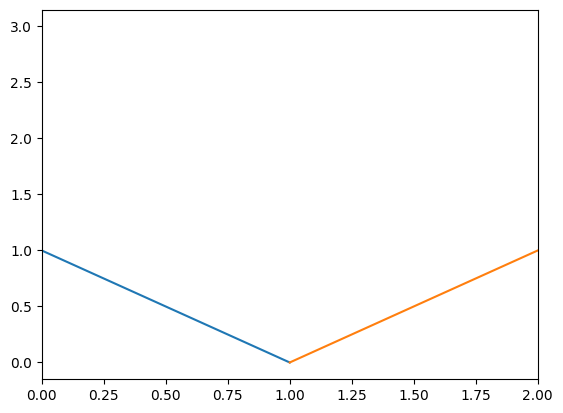

In [198]:
_eq = sp.diff(atk.energy(state), α) \
    .subs({u: _u0, α: α}) \
    .simplify()

_ah = sp.solve(_eq, α)


_ah_f = [sp.lambdify(t, a.subs(_matpar), "numpy") for a in _ah]

# _ahp = sp.lambdify(t, _ah_sub[0].subs(_matpar), "numpy")

_times = np.linspace(0., 3)

for _a in _ah_f:
    plt.plot([_a(t)+2 for t in _times], _times)

plt.xlim(0, _matpar[k])
# plt.plot()

### ATn

In [38]:
## Simple Analytic 
# import visuals

E0, L, w1, η, σc = sp.symbols('E0 L w1 η σc')
x, t = sp.symbols('x t')
α = sp.Function('α')(x)
u = sp.Function('u')(x)

n = sp.symbols('n')


#### ATn, n=1 => AT1

In [39]:
state = {u: u, α: α}
matpar = {n: 1, E0: 1, w1: 1, η: η}
_matpar = {n: 1, L: 1, E0: 1, w1: 1, η: η}

at1 = DamageATn(state, matpar={n: 1, E0: 1, w1: w1, η: η, L: L}, name="at1")
ana = ModelAnalysis(model = at1)
ana.criterion()


1 - 1.0*t**2/L**2

In [40]:
ana.critical_load()

[{t**2: L**2}]

In [41]:
sp.solve(t**2 - ana.critical_load()[0][t**2], t)

[-L, L]

In [42]:
ana.critical_load_N(_matpar)

(array([1]),)

In [43]:
ana._homogeneous_alpha()

[-L**2/t**2 + 1.0]

(-0.1, 1.0)

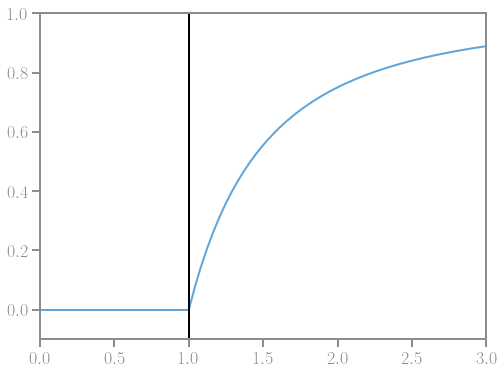

In [45]:

fig, ax = ana.plot_homogeneous_alpha(_matpar)
ax.set_ylim(-0.1, 1)


In [46]:

fig, ax = ana.plot_homogeneous_stress(_matpar)


[-L**2/t**2 + 1.0]

In [23]:
_ah = ana._homogeneous_alpha()[0]
_s = sp.sqrt( 2* ana._wp / ana._sp).subs({α: _ah})

_sn = sp.lambdify(t, _s.subs(_matpar), "numpy")


<lambdifygenerated-43>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return select([greater_equal(t, 1),True], [sqrt((1 - select([greater_equal(t, 1),True], [1.0 - 1/t**2,0], default=nan))**3),t], default=nan)


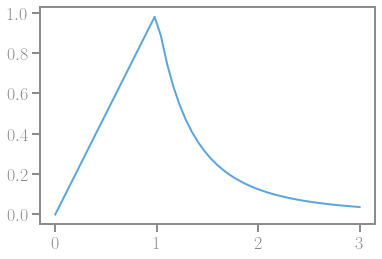

In [51]:
_sh = ana._stress()
_sn = sp.lambdify(t, _sh.subs(_matpar), "numpy")
plt.plot(_times, [_sn(t) for t in _times])


In [20]:

_homog_state, (_uf, _af) = ana._homogeneous_state(_matpar)
# ax.set_ylim(-0.1, 1)

_af
# ax.draw()
# fig.show()

<function _lambdifygenerated(t)>

In [34]:
(_homog, _homog_f) = ana._homogeneous_state(_matpar)

In [22]:
_u = _homog[0]
_alpha = _homog[1]


_homog_state = {α: _homog[1], u: _homog[0]}

In [23]:
at1.energy(_homog_state).subs({α: _homog[1]})

Piecewise((-L**2/t**2 + 1.0, t >= 1), (0, True)) + 0.5*t**2*(1 - Piecewise((-L**2/t**2 + 1.0, t >= 1), (0, True)))**2/L**2

In [24]:
_en_h = sp.lambdify(t, at1.energy(_homog_state).subs({α: _homog[1]}).subs(_matpar), "numpy")
_en_dam_h = sp.lambdify(t, at1._damage(_homog_state).subs({α: _homog[1]}).subs(_matpar), "numpy")
_en_ela_h = sp.lambdify(t, at1._elastic(_homog_state).subs({α: _homog[1]}).subs(_matpar), "numpy")

plt.plot(np.linspace(0., 3.), [_en_h(t) for t in np.linspace(0., 3.)], c="C0")
plt.plot(np.linspace(0., 3.), [_en_dam_h(t) for t in np.linspace(0., 3.)], c="C1")
plt.plot(np.linspace(0., 3.), [_en_ela_h(t) for t in np.linspace(0., 3.)], c="C2")


<lambdifygenerated-8>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.5*t**2*(1 - select([greater_equal(t, 1),True], [1.0 - 1/t**2,0], default=nan))**2 + select([greater_equal(t, 1),True], [1.0 - 1/t**2,0], default=nan)
<lambdifygenerated-9>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return select([greater_equal(t, 1),True], [1.0 - 1/t**2,0], default=nan)
<lambdifygenerated-10>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 0.5*t**2*(1 - select([greater_equal(t, 1),True], [1.0 - 1/t**2,0], default=nan))**2


<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (_Dummy_330 - 1)**(-2.0)
<lambdifygenerated-14>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return -2/(_Dummy_331 - 1)**3
<lambdifygenerated-15>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 6/(_Dummy_332 - 1)**4


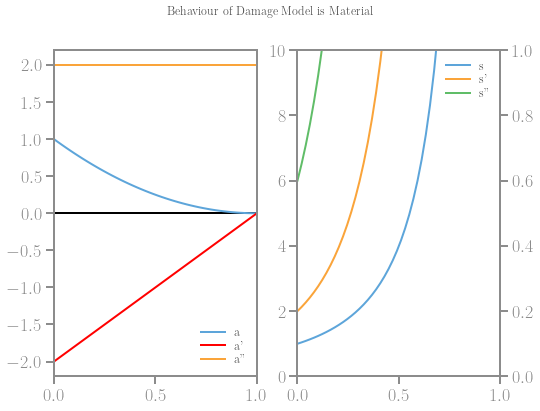

In [55]:
ana.plot_material()

In [ ]:
# Localised branches
••

In [66]:
ah = ana._homogeneous_alpha()
_tc = ana.critical_load_N(_matpar)[0][0]

# _af = sp.lambdify(t, ah[0].subs(_matpar), "numpy")

_homogeneous_alpha = sp.Piecewise((ah[0], t >= _tc), (0, t < _tc))

_af = sp.lambdify(t, _homogeneous_alpha.subs(_matpar), "numpy")



<lambdifygenerated-20>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return select([greater_equal(t, 1),True], [1.0 - 1/t**2,0], default=nan)


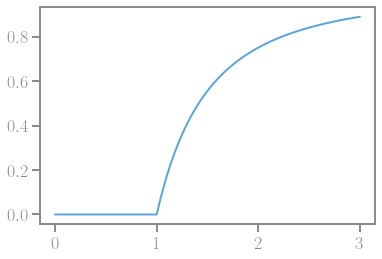

In [69]:
plt.plot(np.linspace(0., 3., 100), [_af(t) for t in np.linspace(0., 3., 100)], c="C0")


### PQ

In [156]:
state = {u: u, α: α}
p, q, E0, L, w1, η, σc = sp.symbols('p q E0 L w1 η σc')

# _matpar = {n: 1, L: 1, E0: 1, w1: 1, η: η}

dpq = DamagePQ(state, matpar={}, name="pq")
ana = ModelAnalysis(model = dpq)
ana.criterion()


(p + q)*(-0.5*E0**2*t**2/L**2 + σc**2)/E0

In [151]:
_sp.subs({α: 0})

p + q

In [157]:
ana._deps_1_d_dσ()

-8.88576587631673*E0*σc**2*(p + q)**2/(σc**2*(p**3 + 3*p**2*q - 3*p**2 + 3*p*q**2 + 2*p + q**3 + 3*q**2 + 2*q))**1.5

In [159]:
ana._deps_1_d_dσ() \
    .subs({E0: 1, σc: 1})

-8.88576587631673*(p + q)**2/(p**3 + 3*p**2*q - 3*p**2 + 3*p*q**2 + 2*p + q**3 + 3*q**2 + 2*q)**1.5

In [174]:
_u0 = t*x/L

_eq = sp.diff(ana.model.energy(state), α)   \
    .subs({u: _u0, α: α})                   \
    .subs({E0: 1, w1: 1, p:2, q: 2, σc:1, L:1 })                   \
    .simplify()

_eq.simplify()

_ans = sp.solve(_eq, α)

In [190]:
ah = ana._homogeneous_alpha()


NotImplementedError: multiple generators [(1 - _X0)**q, (_X0 + 1)**p, _X0]
No algorithms are implemented to solve equation E0**2*p*t**2*(1 - _X0)**(q + 1)*(_X0 + 1)**p/(2*L**2) + E0**2*q*t**2*(1 - _X0)**q*(_X0 + 1)**(p + 1)/(2*L**2) + σc**2*(_X0 - 1)*(_X0 + 1)**(2*p + 1)*(p + q)

In [180]:
len(_ans)

3

<lambdifygenerated-48>:2: RuntimeWarning: invalid value encountered in double_scalars
  return 0.209986841649146*t**2/(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 0.7937005259841*(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 1.0
<lambdifygenerated-49>:2: RuntimeWarning: invalid value encountered in cdouble_scalars
  return 0.209986841649146*t**2*(-0.5 - 0.866025403784439*1j)/(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 0.7937005259841*(-0.5 + 0.866025403784439*1j)*(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 1.0
/opt/homebrew/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
<lambdifygenerated-50>:2: RuntimeWarning: invalid value encountered in cdouble_scalars
  return 0.209986841649146*t**2*(-0.5 + 0.866025403784439*1j)/(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 0.7937005259841*(-0.5 - 0.866025403784439*1j)*(-t**2

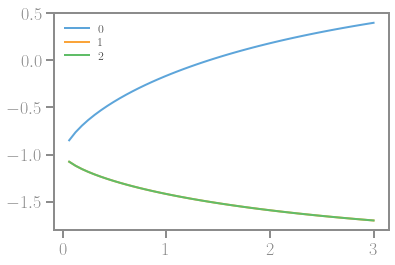

In [185]:
for i, _a in enumerate(_ans):
    _af = sp.lambdify(t, _a, "numpy")
    plt.plot(np.linspace(0., 3.), [_af(t) for t in np.linspace(0., 3.)], label=f"{i}")

plt.legend()


<lambdifygenerated-54>:2: RuntimeWarning: invalid value encountered in double_scalars
  return 0.209986841649146*t**2/(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 0.7937005259841*(-t**2 + sqrt(0.0185185185185185*t**6 + t**4))**(1/3) - 1.0


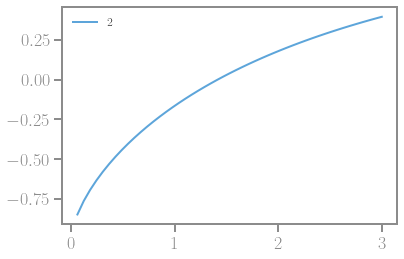

In [189]:
_af = sp.lambdify(t, _ans[0], "numpy")
plt.plot(np.linspace(0., 3.), [_af(t) for t in np.linspace(0., 3.)], label=f"{i}")

plt.legend()
